In [1]:
import sympy
sympy.init_printing()

In [2]:
def si_drived_unit_equivalent(unit_string:str) -> str:
    assert ' ' not in unit_string, 'Invalid space character'
    
    si_drived_units = {'N': 'kg m s^-2', 'J': 'kg m^2 s^-2', 'C':'A s',
                       'T': 'kg s^-2 A^-1', 'Pa':'kg m^-1 s^-2',
                       'W':'kg m^2 s^-3', 'Hz':'s^-1', 'V':'kg m^2 s^−3 A^−1',
                       'F':'kg^−1 m^−2 s^4 A^2', 'Wb':'kg m^2 s^−2 A^−1',
                       'H':'kg m^2 s^−2 A^−2', 'ohm':'kg m^2 s^−3 A^−2',
                       'rad':'', 'sr':''}
    
    if '^' in unit_string:
        unit_part = unit_string.split('^')[0]
        power_part = int(unit_string.split('^')[1])
    else:
        unit_part = unit_string
        power_part = 1
    
    if unit_part in si_drived_units:
        unit_part = si_drived_units[unit_part]            
        unit_list = [unit_part for instance in range(power_part)]
        return ' '.join(unit_list)
    else:    
        return unit_string

def symplify_drived_units(unit_string:str) -> str:
    unit_list = []
    for unit in unit_string.split(' '):
        unit_list.append(si_drived_unit_equivalent(unit))
    return ' '.join(unit_list)

In [3]:
def si_parser(unit_string:str) -> dict:
    from sympy.physics import units
    
    si_system = {'m': units.length, 's': units.time,
                 'k': units.temperature, 'kg': units.mass,
                 'mol': units.amount_of_substance, 'A': units.current,
                 'cd': units.luminous_intensity}
    unit_string = symplify_drived_units(unit_string)
    
    result_unit = 1
    for unit in unit_string.split(' '):
        
        if '^' in unit:
            unit_part = unit.split('^')[0]
            power_part = int(unit.split('^')[1])
        else:
            unit_part = unit
            power_part = 1            
        
        result_unit *= (si_system[unit_part]**power_part)

    return result_unit

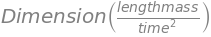

In [4]:
f = si_parser('N')
f

# Dimensional Analysis

In [5]:
def parameter(name:str, unit:str, latex_repr:str):
    from sympy.physics.units import Quantity
    from sympy.physics.units.systems import SI
    
    parameter = Quantity(name, latex_repr=latex_repr)
    SI.set_quantity_dimension(parameter, si_parser(unit))
    return parameter

In [6]:
class DimensionalAnalysis:
    def __init__(self, paramters:list):
        self.parameters = paramters
        
    @property
    def fundamental_dimensions(self):
        from sympy.physics.units.systems.si import dimsys_SI
        dimensions = set()
        for parameter in parameters:
            dimension_dict = dimsys_SI.get_dimensional_dependencies(parameter.dimension)
            for dimension in dimension_dict:
                dimensions.add(dimension)
        return dimensions
    
    @property
    def dimension_matrix(self):
        from sympy.physics.units.systems.si import dimsys_SI
        matrix = sympy.zeros(len(self.fundamental_dimensions),
                             len(self.parameters))
        for i, dimension in enumerate(self.fundamental_dimensions):
            for j, parameter in enumerate(self.parameters):
                dimension_dict = dimsys_SI.get_dimensional_dependencies(parameter.dimension)
                if dimension in dimension_dict:
                    matrix[i,j] = dimension_dict[dimension]
                else:
                    matrix[i,j] = 0

        return matrix
    
    @property
    def dimensionless_parameters(self):
        dimesionless_dict = dict()
        nullspace = self.dimension_matrix.nullspace()
        for i, vector in enumerate(nullspace):
            d = 1
            for j, power in enumerate(vector):
                if power - int(power) == 0:
                    power = int(power) # Prefer using integer powers if possible
                d *= (self.parameters[j]**power)
                dimesionless_dict[sympy.symbols(f'Pi_{i}')] = d

        return dimesionless_dict
    
    def solve_for(self, parameter):
        solution_dict = dict()
        dimensionless_dict = self.dimensionless_parameters
        for d in dimensionless_dict:
            solution = sympy.solve(sympy.Eq(dimensionless_dict[d], d),
                                   parameter)
            solution_dict[d] = solution
        return solution_dict

# Fluid Flow

In [7]:
density = parameter('density', 'kg m^-3', '\\rho')
viscosity = parameter('viscosity', 'kg m^-1 s^-1', '\mu')
velocity = parameter('velocity', 'm s^-1', 'u')
diameter = parameter('diameter', 'm', 'D')

In [37]:
viscosity.dimension
viscosity

In [38]:
parameters = [density, viscosity, velocity, diameter]

In [39]:
analyze = DimensionalAnalysis(parameters)
(analyze.dimensionless_parameters)

In [40]:
analyze.solve_for(velocity)

# Pendulum

In [40]:
period = parameter('period', 's', 'T')
g = parameter('g', 'm s^-2', 'g')
length = parameter('length', 'm', 'L')

In [41]:
parameters = [period, g, length]

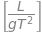

In [42]:
analyze = DimensionalAnalysis(parameters)
analyze.dimensionless_parameters

In [43]:
analyze.solve_for(period)

# Fluid Static

In [44]:
pressure = parameter('pressure', 'Pa', 'P')
density = parameter('density', 'kg m^-3', '\\rho')
g = parameter('g', 'm s^-2', 'g')
height = parameter('height', 'm', 'h')

In [45]:
parameters = [pressure, density, g, height]

In [46]:
analyze = DimensionalAnalysis(parameters)
analyze.dimensionless_parameters

In [47]:
analyze.solve_for(pressure)

# Wave Equation

In [48]:
wave_length = parameter('wave length', 'm', '\lambda')
velocity = parameter('velocity', 'm s^-1', 'C')
period = parameter('period', 's', 'T')

In [49]:
parameters = [wave_length, velocity, period]

In [50]:
analyze = DimensionalAnalysis(parameters)
analyze.dimensionless_parameters

In [51]:
analyze.solve_for(wave_length)